In [1]:
import joblib
from sklearn.preprocessing import StandardScaler , MinMaxScaler, RobustScaler
from sklearn.model_selection import LeaveOneOut
import xgboost as xgb
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
# from envs.filtr_json_from_race import load_from_db
import sqlite3
import json
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error, r2_score
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.model_selection import KFold

In [2]:


class LSTMStatePredictor(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1,dropout_prob=0.3):
        super(LSTMStatePredictor, self).__init__()
        
        # Zapisz parametry (potrzebne do ewentualnego ręcznego
        # tworzenia stanu, choć nie jest to już wymagane w forward)
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        lstm_dropout_prob = dropout_prob if num_layers > 1 else 0.0
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True,dropout=lstm_dropout_prob)

        self.dropout_layer = nn.Dropout(dropout_prob)
    
        # Twój świetny pomysł z wieloma głowicami - zostaje!
        self.heads = nn.ModuleList([
            nn.Linear(hidden_size, 2),  # progress
            nn.Linear(hidden_size, 1),  # fuel
            nn.Linear(hidden_size, 4),  # wear
            nn.Linear(hidden_size, 4),  # temp
            nn.Linear(hidden_size, 1)   # track wetness
        ])

        # Te pola nie są już potrzebne Wewnątrz modelu
        # self.scaler_X = None
        # self.scaler_Y = None
        # self.n_steps_ahead = n_steps_ahead # Usuwamy n_steps_ahead
        self.output_size = output_size

    def forward(self, x, h_c=None):
        # 1. Nie musisz ręcznie inicjować h_c. 
        #    nn.LSTM zrobi to automatycznie, jeśli h_c jest None.
        
        # 2. Przetwórz CAŁĄ sekwencję
        #    x ma kształt: [B, seq_len, 37]
        #    out będzie miał kształt: [B, seq_len, hidden_size]
        out, h_c = self.lstm(x, h_c) 

        out = self.dropout_layer(out)  # Zastosuj dropout do wyjścia LSTM
        
        # 3. Zastosuj głowice do CAŁEGO tensora 'out', a nie tylko 'out[:, -1, :]'
        #    head(out) da np. [B, seq_len, 2]
        outputs = [head(out) for head in self.heads]
        
        # 4. Połącz wzdłuż ostatniego wymiaru (wymiaru cech)
        #    List of [B,S,2], [B,S,1], [B,S,4]... -> [B, S, 12]
        #    Używamy dim=2, ponieważ kształt to (Batch, Seq_len, Features)
        combined = torch.cat(outputs, dim=2) 
        
        return combined, h_c
    

def create_scalers(X,Y):

    cont_indices_x = slice(0, 19)   # continuous columns for X (0–18)
    cont_indices_y = slice(0, 12)   # continuous columns for Y (0–11)

    # Scale continuous features
    flat_x = np.vstack([x[:, cont_indices_x] for x in X])
    flat_y = np.vstack([y[:, cont_indices_y] for y in Y])

    # scaler_X = MinMaxScaler().fit(flat_x)
    # # scaler_Y = MinMaxScaler().fit(flat_y)
    # scaler_Y = StandardScaler().fit(flat_y)
    scaler_X = RobustScaler().fit(flat_x)
    scaler_Y = RobustScaler().fit(flat_y)
    return scaler_X, scaler_Y


def scale_input(X, Y, scaler_X, scaler_Y):
    cont_indices_x = slice(0, 19)   # continuous columns for X
    cont_indices_y = slice(0, 12)   # continuous columns for Y

    X_scaled_grouped = []
    Y_scaled_grouped = []

    for x_seq, y_seq in zip(X, Y):
        x_scaled = np.array(x_seq, dtype=float)
        x_scaled[:, cont_indices_x] = scaler_X.transform(x_seq[:, cont_indices_x])
        X_scaled_grouped.append(x_scaled)

        y_scaled = np.array(y_seq, dtype=float)
        y_scaled[:, cont_indices_y] = scaler_Y.transform(y_seq[:, cont_indices_y])
        Y_scaled_grouped.append(y_scaled)

    # Conversion to torch tensors
    # X_t = [torch.tensor(x, dtype=torch.float32) for x in X_scaled_grouped]
    # Y_cont_t = [torch.tensor(y[:, cont_indices_y], dtype=torch.float32) for y in Y_scaled_grouped]

    return X_scaled_grouped, Y_scaled_grouped

In [2]:
def load_data_from_db():
    
    """
    Load data so that each race is a separate sequence:
    X = [ [state1_race1, state2_race1, ...], [state1_race2, ...] ]
    Y = [ [next1_race1, next2_race1, ...], ... ]
    """
    conn = sqlite3.connect(
        "E:/pracadyp/Race-optimization-reinforcement-learning/data/db_states_for_regress/race_data_states.db"
    )
    cursor = conn.cursor()
    cursor.execute("SELECT race_id, states_json FROM races ORDER BY race_id")
    rows = cursor.fetchall()
    conn.close()


    data = []

    for race_id, states_json in rows:
        states = json.loads(states_json)
        data.append(states)
    
    return data

def create_windows(sequence_x, sequence_y, window_size, n_steps_ahead=5):
    X, Y = [], []
    for t in range(1, len(sequence_x)):
        start = max(0, t - window_size)
        window = sequence_x[start:t]

        # padding na początku, jeśli okno krótsze niż window_size
        pad_len = window_size - len(window)
        if pad_len > 0:
            window = np.vstack([np.zeros((pad_len, sequence_x.shape[1])), window])
        X.append(window)

        # Y: wypełniamy zerami, jeśli końcówka wyścigu ma mniej niż n_steps_ahead
        y_window = sequence_y[t:t+n_steps_ahead]
        if y_window.shape[0] < n_steps_ahead:
            pad = np.zeros((n_steps_ahead - y_window.shape[0], sequence_y.shape[1]))
            y_window = np.vstack([y_window, pad])
        Y.append(y_window)

    return np.array(X), np.array(Y)

def create_x_y(data):
    X_grouped, Y_grouped = [], []

    for race in data:
        X_seq, Y_seq = [], []
        for i in range(len(race) - 1):
            X_seq.append(race[i][:-2])
            Y_seq.append(race[i + 1][:-27]) 
        
        # dodajemy każdy wyścig osobno
        X_grouped.append(np.array(X_seq, dtype=float))
        Y_grouped.append(np.array(Y_seq, dtype=float))

    return X_grouped, Y_grouped

In [5]:
def create_sliding_windows(races_x_list, races_y_list, sequence_length, step=1):
    """
    Tworzy próbki (X, Y) metodą przesuwnego okna dla Teacher Forcing.
    X = [t, t+1, ..., t+seq_len-1]
    Y = [t+1, t+2, ..., t+seq_len]  (przesunięte o 1)
    """
    all_X_samples = []
    all_Y_samples = []
    
    # Pamiętaj, że race_y to już wyodrębnione 12 cech
    # race_x to pełne 37 cech
    
    for race_x, race_y in zip(races_x_list, races_y_list):
        race_length = race_x.shape[0]
        
        # Pętla po pojedynczym wyścigu
        # Ostatni indeks startowy `i` musi być taki, aby `i + sequence_length`
        # nie wyszło poza zakres dla Y (który jest przesunięty o 1)
        for i in range(0, race_length - sequence_length, step):
            
            # X: Kształt (sequence_length, 37)
            x_sample = race_x[i : i + sequence_length]
            
            # Y: Kształt (sequence_length, 12)
            # Dla wejścia X w kroku 't', celem jest Y z kroku 't+1'
            y_sample = race_y[i + 1 : i + sequence_length + 1] 
            
            all_X_samples.append(x_sample)
            all_Y_samples.append(y_sample)
            
    return np.array(all_X_samples), np.array(all_Y_samples)

Nowa wersja uczenia dla testów

37 12
Testing weight: [0.5, 1.8, 3.0, 0.1, 1.5]
Tworzenie sampli treningowych...
Tworzenie sampli testowych...
Kształt X_train_samples: (53740, 200, 37)
Kształt Y_train_samples: (53740, 200, 12)
Using device: cuda
Finalny test loss po 80 : 0.03303641523809436


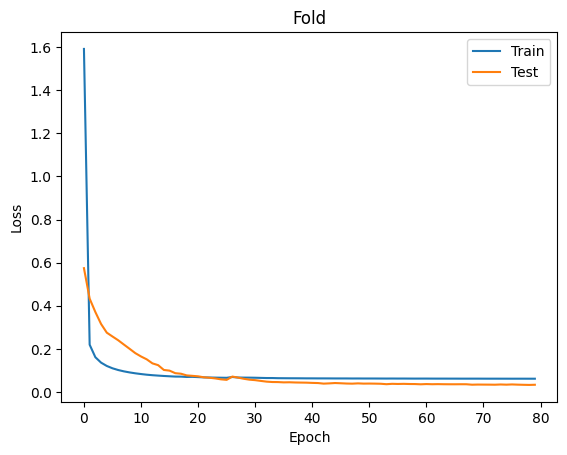

Tworzenie sampli treningowych...
Tworzenie sampli testowych...
Kształt X_train_samples: (50123, 200, 37)
Kształt Y_train_samples: (50123, 200, 12)
Using device: cuda
Finalny test loss po 80 : 0.14594663798791963


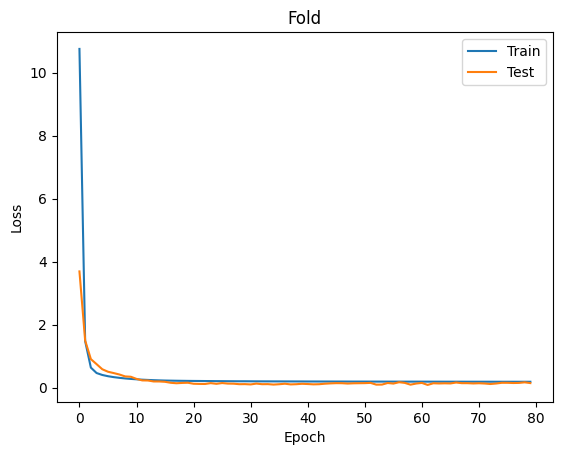

Tworzenie sampli treningowych...
Tworzenie sampli testowych...
Kształt X_train_samples: (48552, 200, 37)
Kształt Y_train_samples: (48552, 200, 12)
Using device: cuda
Finalny test loss po 80 : 0.8803537150032911


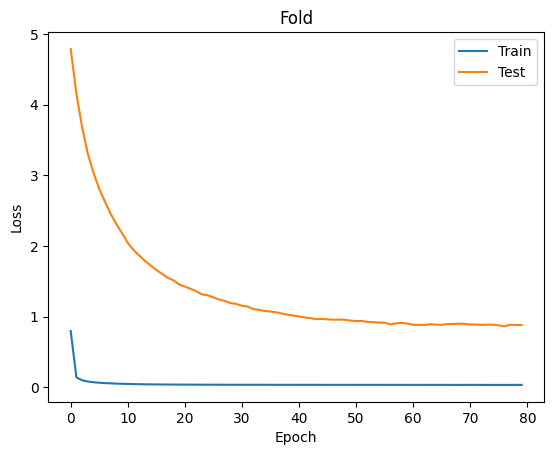

Tworzenie sampli treningowych...
Tworzenie sampli testowych...
Kształt X_train_samples: (53575, 200, 37)
Kształt Y_train_samples: (53575, 200, 12)
Using device: cuda
Finalny test loss po 80 : 0.0497759218077834


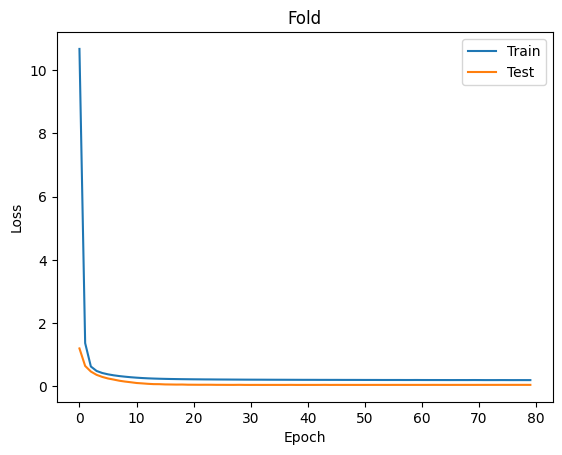

Tworzenie sampli treningowych...
Tworzenie sampli testowych...
Kształt X_train_samples: (49950, 200, 37)
Kształt Y_train_samples: (49950, 200, 12)
Using device: cuda
Finalny test loss po 80 : 0.05101731582015583


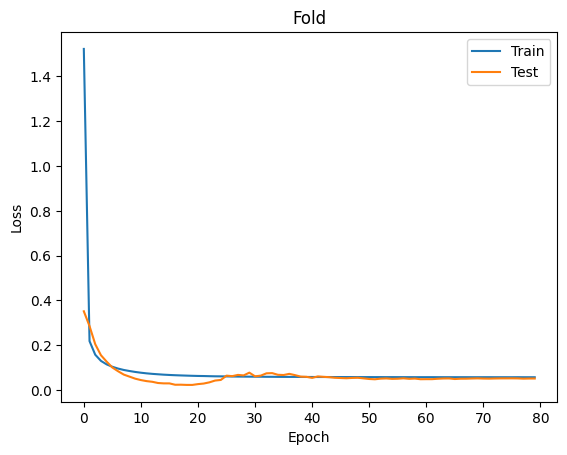

In [ ]:

import gc


data = load_data_from_db()
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
# torch.use_deterministic_algorithms(True)

X, Y = create_x_y(data)
input_size = X[0].shape[1]
output_size = Y[0].shape[1]
print(input_size, output_size)



loo = LeaveOneOut()
all_fold_train = []
all_fold_test = []
all_fold_r2_test = []
i = 0

SEQUENCE_LENGTH = 200 # lub 30 jeśli wolisz, ale musi być spójne
STEP = 1 # step=1 daje najwięcej danych

lr = 1e-4

batch_size = 128
num_epochs = 80
weights = [
    # [1.0, 1.0, 1.0, 1.0, 1.0],
    # [0.8, 1.2, 1.5, 0.5, 1.0],
    [0.7, 1.4, 2.0, 0.3, 1.2],
    [0.6, 1.6, 2.5, 0.2, 1.3],
    [0.5, 1.8, 3.0, 0.1, 1.5],
    [1.0,1.0,2.5,0.1,0.4]
]
weight = [0.5, 1.8, 3.0, 0.1, 1.5]
# weight = weights[4]  # wybierz zestaw wag do testowania
# for weight in weights:

N_SPLITS = 5  # Ustal liczbę foldów (K). 5 lub 10 to dobry start.
kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=42)

print("Testing weight:", weight)
for fold, (train_idx, test_idx) in enumerate(kf.split(X)):
    
    # if fold > 0:
    #     break
    i += 1


    X_train = [X[i] for i in train_idx]
    X_test  = [X[i] for i in test_idx]
    Y_train = [Y[i] for i in train_idx]
    Y_test  = [Y[i] for i in test_idx]

    Y_train_raw = [np.array(y, copy=True) for y in Y_train]  # zapisz oryginalne (nieprzeskalowane)


    # Y_train_raw = Y_train.copy()  # zachowaj surowe Y_train przed skalowaniem

    scaler_X, scaler_Y = create_scalers(X_train,Y_train)

    X_train, Y_train = scale_input(X_train,Y_train,scaler_X,scaler_Y)
    X_test, Y_test = scale_input(X_test,Y_test,scaler_X,scaler_Y)
    n_steps_ahead = 5  # number of future steps to predict


    print("Tworzenie sampli treningowych...")
    X_train_samples, Y_train_samples = create_sliding_windows(
        X_train, Y_train, SEQUENCE_LENGTH, STEP
    )
    print("Tworzenie sampli testowych...")
    X_test_samples, Y_test_samples = create_sliding_windows(
        X_test, Y_test, SEQUENCE_LENGTH, STEP
    )
    
    print(f"Kształt X_train_samples: {X_train_samples.shape}")
    print(f"Kształt Y_train_samples: {Y_train_samples.shape}")

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)
    model = LSTMStatePredictor(input_size=input_size, hidden_size=256, output_size=output_size, num_layers=1).to(device)



    
    
    X_train_tensor = torch.tensor(X_train_samples, dtype=torch.float32).to(device)
    Y_train_tensor = torch.tensor(Y_train_samples, dtype=torch.float32).to(device)
    X_test_tensor = torch.tensor(X_test_samples, dtype=torch.float32).to(device)
    Y_test_tensor = torch.tensor(Y_test_samples, dtype=torch.float32).to(device)

    train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    test_dataset = TensorDataset(X_test_tensor, Y_test_tensor)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # optimizer = optim.Adam(model.parameters(), lr=lr)
    

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.8, patience=5)
    loss_cont = nn.MSELoss()
    loss_cat  = nn.CrossEntropyLoss()

    fold_train_losses = []
    fold_test_losses = []
    # num_epochs = 100
    all_r2_per_output = []
    fold_r2_scores = []

    
    
    for epoch in range(num_epochs):
        
        model.train()
        total_train_loss = 0

      
        

        for x_batch, y_batch in train_loader:
            optimizer.zero_grad()
            
            # Model dostaje całą sekwencję 200 kroków
            # i zwraca predykcje dla całej sekwencji 200 kroków
            y_pred, _ = model(x_batch) 
            
            # y_pred ma kształt (batch_size, SEQUENCE_LENGTH, 12)
            
            # Obliczamy stratę dla całej sekwencji na raz
            # Musimy indeksować wymiar cech [:, :, ...]
            loss_progress = loss_cont(y_pred[:, :, 0:2], y_batch[:, :, 0:2])
            loss_fuel     = loss_cont(y_pred[:, :, 2:3], y_batch[:, :, 2:3])
            loss_wear     = loss_cont(y_pred[:, :, 3:7], y_batch[:, :, 3:7])
            loss_temp     = loss_cont(y_pred[:, :, 7:11], y_batch[:, :, 7:11])
            loss_wet      = loss_cont(y_pred[:, :, 11:], y_batch[:, :, 11:])
            
            # Sumujemy straty (tak jak miałeś)
            loss = (weight[0] * loss_progress + 
                    weight[1] * loss_fuel + 
                    weight[2] * loss_wear + 
                    weight[3] * loss_temp + 
                    weight[4] * loss_wet)
            
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        scheduler.step(avg_train_loss)
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}")

        

        model.eval()
        total_test_loss = 0
        with torch.no_grad():
            for x_batch, y_batch in test_loader:
                y_pred, _ = model(x_batch)
                
                loss_progress = loss_cont(y_pred[:, :, 0:2], y_batch[:, :, 0:2])
                loss_fuel     = loss_cont(y_pred[:, :, 2:3], y_batch[:, :, 2:3])
                loss_wear     = loss_cont(y_pred[:, :, 3:7], y_batch[:, :, 3:7])
                loss_temp     = loss_cont(y_pred[:, :, 7:11], y_batch[:, :, 7:11])
                loss_wet      = loss_cont(y_pred[:, :, 11:], y_batch[:, :, 11:])
            
                # ... (oblicz resztę strat) ...

                loss = (weight[0] * loss_progress + weight[1] * loss_fuel + weight[2] * loss_wear + weight[3] * loss_temp + weight[4] * loss_wet)
                total_test_loss += loss.item()
        
        avg_test_loss = total_test_loss / len(test_loader)
        
        # Scheduler używa straty walidacyjnej
        scheduler.step(avg_test_loss)
        fold_train_losses.append(avg_train_loss)
        fold_test_losses.append(avg_test_loss)

        
        # print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}")
    print(f"Finalny test loss po {num_epochs} : {fold_test_losses[-1]}")
    plt.figure()
    plt.plot(fold_train_losses, label='Train')
    plt.plot(fold_test_losses, label='Test')
    plt.title(f'Fold')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    del model
    del optimizer
    del X_train_samples, Y_train_samples
    del X_test_samples, Y_test_samples
    del train_dataset, test_dataset
    del train_loader, test_loader
    
    # 2. Wymuś zwolnienie pamięci RAM
    gc.collect()
    
    # 3. Wymuś zwolnienie pamięci VRAM (GPU)
    if torch.cuda.is_available():
        torch.cuda.empty_cache()


    #     model.eval()
    #     with torch.no_grad():
    #         pred_test = model(X_test_tensor)
    #         test_loss = loss_cont(pred_test, Y_test_tensor).item()
    #         fold_test_losses.append(test_loss)
        
    #         scheduler.step(test_loss)
    #         print(f"Epoch {epoch+1}, current lr: {optimizer.param_groups[0]['lr']:.6f}")

            
    #         if epoch == num_epochs - 1:
    #             b, t, f = pred_test.shape
    #             pred_test_flat = pred_test.cpu().numpy().reshape(b*t, f)
    #             Y_test_flat = Y_test_tensor.cpu().numpy().reshape(b*t, f)

    #             # inverse transform
    #             pred_test_inv = scaler_Y.inverse_transform(pred_test_flat)
    #             Y_test_inv = scaler_Y.inverse_transform(Y_test_flat)

    #             # R² po cechach
    #             r2s = [r2_score(Y_test_inv[:, i], pred_test_inv[:, i]) for i in range(f)]
    #             avg_r2_per_output = np.mean(r2s)
    #             print("Avg R2 per output:", r2s)
    #             print("Mean R2:", avg_r2_per_output)

    #             # === DIAGNOSTYKA PER-FEATURE ===
    #             from sklearn.metrics import mean_squared_error
    #             print("\n--- DIAGNOSTYKA ---")

    #             # przygotuj dane surowe z treningu (przed skalowaniem!)
    #             # jeśli chcesz pełną dokładność, przechowuj Y_train_raw = Y_train (niezeskalowane) tuż po wczytaniu
    #             # tu tymczasowo przyjmujemy, że masz Y_train nieprzeskalowane dostępne jako oryginalne dane:
    #             flat_y_train = np.vstack([y for y in Y_train_raw])  # jeśli Y_train jest już scaled, zmień to na surowe Y_train_raw

    #             vars_train = flat_y_train.var(axis=0)
    #             means_train = flat_y_train.mean(axis=0)
    #             mins = flat_y_train.min(axis=0)
    #             maxs = flat_y_train.max(axis=0)

    #             print("Feature | var | mean | min | max")
    #             for i in range(f):
    #                 print(i, round(vars_train[i],6), round(means_train[i],6), round(mins[i],6), round(maxs[i],6))

    #             # baseline R² (predykcja średnią z train)
    #             mean_pred = np.tile(means_train.reshape(1,-1), (Y_test_inv.shape[0],1))
    #             baseline_r2 = [r2_score(Y_test_inv[:,i], mean_pred[:,i]) for i in range(f)]
    #             print("\nBaseline R2 per feature:", baseline_r2)

    #             # model R² + MSE + min/max pred
    #             for i in range(f):
    #                 r2 = r2_score(Y_test_inv[:,i], pred_test_inv[:,i])
    #                 mse = mean_squared_error(Y_test_inv[:,i], pred_test_inv[:,i])
    #                 print(f"feat {i}: R2={r2:.4f}, MSE={mse:.6f}, pred_min={pred_test_inv[:,i].min():.4f}, pred_max={pred_test_inv[:,i].max():.4f}")
    #             print("--- KONIEC DIAGNOSTYKI ---\n")

    #             num_features = Y_test_inv.shape[1]
    #             fig, axes = plt.subplots(nrows=(num_features + 2)//3, ncols=3, figsize=(15, 5*((num_features + 2)//3)))
    #             axes = axes.flatten()
    #             titles = ["Race progress","Lap progress","Fuel level","Tyre wear FL","Tyre wear FR","Tyre wear RL","Tyre wear RR",
    #                         "Tyre temp FL","Tyre temp FR","Tyre temp RL","Tyre temp RR","Track wetness"]
    #             for i in range(num_features):
    #                 ax = axes[i]
    #                 ax.scatter(Y_test_inv[:, i], pred_test_inv[:, i], s=10, alpha=0.6)
    #                 ax.plot([Y_test_inv[:, i].min(), Y_test_inv[:, i].max()],
    #                         [Y_test_inv[:, i].min(), Y_test_inv[:, i].max()],
    #                         'r--', linewidth=1.5, label='ideal line')
    #                 ax.set_title(f'{titles[i]} | R²={r2s[i]:.3f}')
    #                 ax.set_xlabel('True')
    #                 ax.set_ylabel('Predicted')
    #                 ax.legend()
    #                 ax.grid(True)

    #             for j in range(i+1, len(axes)):
    #                 fig.delaxes(axes[j])

    #             plt.tight_layout()
    #             plt.show()

    #             num_features = Y_test_inv.shape[1]
    #             titles = ["Race progress","Lap progress","Fuel level",
    #                     "Tyre wear FL","Tyre wear FR","Tyre wear RL","Tyre wear RR",
    #                     "Tyre temp FL","Tyre temp FR","Tyre temp RL","Tyre temp RR",
    #                     "Track wetness"]

    #             cols = 3
    #             rows = int(np.ceil(num_features / cols))
    #             fig, axes = plt.subplots(rows, cols, figsize=(18, rows * 3))
    #             axes = axes.flatten()

    #             for i in range(num_features):
    #                 ax = axes[i]
    #                 ax.plot(Y_test_inv[:, i], label='True', color='blue', linewidth=1)
    #                 ax.plot(pred_test_inv[:, i], label='Pred', color='orange', linestyle='--', linewidth=1)
    #                 ax.set_title(f'{titles[i]} | R²={r2s[i]:.3f}')
    #                 ax.set_xlabel('Sample index')
    #                 ax.set_ylabel('Value')
    #                 ax.legend()
    #                 ax.grid(True)

    #             # usuń puste osie, jeśli niepełny ostatni rząd
    #             for j in range(i+1, len(axes)):
    #                 fig.delaxes(axes[j])

    #             plt.tight_layout()
    #             plt.show()
                                                
    # plt.figure()
    # plt.plot(fold_train_losses, label='Train')
    # plt.plot(fold_test_losses, label='Test')
    # plt.title(f'Fold')
    # plt.xlabel('Epoch')
    # plt.ylabel('Loss')
    # plt.legend()
    # plt.show()

del model, X_train_tensor, Y_train_tensor, X_test_tensor, Y_test_tensor
torch.cuda.empty_cache()

In [ ]:
del model, X_train_tensor, Y_train_tensor, X_test_tensor, Y_test_tensor
torch.cuda.empty_cache()